# 1. Prepare Data for Merging

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import packages
import pandas as pd
import numpy as np

## - ZHVI

In [3]:
zhvi_df = pd.read_csv('/content/drive/MyDrive/MADS Capstone Team 23/Data/processed/processed_zhvi_df.csv')
zhvi_df = zhvi_df.drop(columns=['Unnamed: 0'])
zhvi_df.head()

,City,Date,ZHVI
0,New York,2010-01,393767.004762
1,Los Angeles,2010-01,418680.256759
2,Chicago,2010-01,201888.606600
3,Dallas,2010-01,150742.550106
4,Seattle,2010-01,333469.123267


## - Crime Data

In [4]:
cities = [('chicago','Chicago'), ('dallas', "Dallas"), ('losangeles', 'Los Angeles'), ('newyork', 'New York'), ('seattle', 'Seattle')]

In [5]:
# Create result df
crime_df = pd.DataFrame()

for city, city_name in cities:
  print(f"processing {city}-{city_name}")

  # Load df from csv
  city_property_crime_df = pd.read_csv(f'/content/drive/MyDrive/MADS Capstone Team 23/Data/processed/Crime/{city}_property_crimes_by_month.csv')
  city_violent_crime_df = pd.read_csv(f'/content/drive/MyDrive/MADS Capstone Team 23/Data/processed/Crime/{city}_violent_crimes_by_month.csv')

  # Rename columns
  city_property_crime_df.rename(columns={"NumberOfIncident": "PropertyCrimeIncident"}, inplace=True)
  city_violent_crime_df.rename(columns={"NumberOfIncident": "ViolentCrimeIncident"}, inplace=True)

  # Merge dataframes
  merged_df = pd.merge(city_property_crime_df, city_violent_crime_df, on='Date')

  # Add city column
  merged_df['City'] = city_name

  # Append the merged DataFrame for the current city to the combined DataFrame
  crime_df = pd.concat([crime_df, merged_df], ignore_index=True)

crime_df.head()

processing chicago-Chicago
processing dallas-Dallas
processing losangeles-Los Angeles
processing newyork-New York
processing seattle-Seattle


,Date,PropertyCrimeIncident,ViolentCrimeIncident,City
0,2001-01,18521.0,11172.0,Chicago
1,2001-02,16068.0,10088.0,Chicago
2,2001-03,18915.0,12906.0,Chicago
3,2001-04,19099.0,13392.0,Chicago
4,2001-05,19794.0,14403.0,Chicago


## - New Home Permit

In [6]:
home_permit_df = pd.read_csv('/content/drive/MyDrive/MADS Capstone Team 23/Data/processed/NewHomeBuilt/newhome_permits_2010_2024.csv')
home_permit_df = pd.melt(home_permit_df, id_vars=['city'], var_name='Date', value_name='NewHomePermits')
home_permit_df.rename(columns={'city': 'City'}, inplace=True)
home_permit_df.head()

,City,Date,NewHomePermits
0,New York,2010-01,874.0
1,Chicago,2010-01,345.0
2,Los Angeles,2010-01,433.0
3,Dallas,2010-01,1565.0
4,Seattle,2010-01,1190.0


## - Population Migration

In [7]:
def process_and_interpolate(df, city_name):
  df['Year'] = pd.to_datetime(df['Year'], format='%Y')

  # Set the 'Year' column as the index
  df.set_index('Year', inplace=True)

  # Create a date range for the monthly index within the range of years
  monthly_index = pd.date_range(start='2010-01-01', end='2022-12-01', freq='MS')

  # Reindex the DataFrame to the new monthly index
  df_monthly = df.reindex(monthly_index)

  # Interpolate the missing values
  df_monthly = df_monthly.interpolate(method='linear')

  df_monthly = df_monthly.round(0).astype(int)

  df_monthly['City'] = city_name

  df_monthly.reset_index(inplace=True)

  df_monthly.rename(columns={'index': 'Date'}, inplace=True)

  df_monthly['Date'] = df_monthly['Date'].dt.strftime('%Y-%m')

  return df_monthly

In [8]:
cities = [('Chicago','Chicago'), ('Dallas', "Dallas"), ('LosAngeles', 'Los Angeles'), ('NewYork', 'New York'), ('Seattle', 'Seattle')]

In [9]:
all_cities_data = []

for city, city_name in cities:
  print(f"processing {city}-{city_name}")
  city_df = pd.read_csv(f'/content/drive/MyDrive/MADS Capstone Team 23/Data/processed/Population/Population_{city}_2010_2022.csv')
  city_df = process_and_interpolate(city_df, city_name)
  all_cities_data.append(city_df)

population_migration_df = pd.concat(all_cities_data, ignore_index=True)
population_migration_df.head()

processing Chicago-Chicago
processing Dallas-Dallas
processing LosAngeles-Los Angeles
processing NewYork-New York
processing Seattle-Seattle


,Date,Population_In_Housing_Units,Owner_Occupied_Population,Renter-Occupied-Population,OOP_Moved_From_Different_County,OOP_Moved_From_Different_State,OOP_Moved_From_Abroad,ROP_Moved_From_Different_County,ROP_Moved_From_Different_State,ROP_Moved_From_Abroad,City
0,2010-01,9206524,6353379,2853145,63533,44473,12706,91300,97006,34237,Chicago
1,2010-02,9208651,6351028,2857623,62982,44984,13228,92170,97885,34291,Chicago
2,2010-03,9210778,6348678,2862100,62432,45494,13751,93040,98764,34344,Chicago
3,2010-04,9212906,6346328,2866578,61881,46005,14273,93910,99643,34398,Chicago
4,2010-05,9215033,6343977,2871056,61331,46516,14796,94780,100522,34452,Chicago


# 2. Merge Data

In [10]:
merged_df = zhvi_df.merge(home_permit_df, on=['City', 'Date'], how='inner')
merged_df = merged_df.merge(population_migration_df, on=['City', 'Date'], how='inner')
merged_df = merged_df.merge(crime_df, on=['City', 'Date'], how='inner')

In [11]:
from sklearn.preprocessing import OneHotEncoder
merged_df["Date"] = pd.to_datetime(merged_df['Date'])
merged_df = merged_df.sort_values(['City', 'Date'])

In [12]:
merged_df.head(2)

,City,Date,ZHVI,NewHomePermits,Population_In_Housing_Units,Owner_Occupied_Population,Renter-Occupied-Population,OOP_Moved_From_Different_County,OOP_Moved_From_Different_State,OOP_Moved_From_Abroad,ROP_Moved_From_Different_County,ROP_Moved_From_Different_State,ROP_Moved_From_Abroad,PropertyCrimeIncident,ViolentCrimeIncident
2,Chicago,2010-01-01,201888.60660,345.0,9206524,6353379,2853145,63533,44473,12706,91300,97006,34237,14429.0,8335.0
7,Chicago,2010-02-01,201527.55114,370.0,9208651,6351028,2857623,62982,44984,13228,92170,97885,34291,11584.0,7056.0


In [ ]:
# Save the merged data to csv
merged_df.to_csv('/content/drive/MyDrive/MADS Capstone Team 23/Data/processed/merged_population_crime_homepermit.csv', index=False)

In [ ]:
## TODO Train a Naive Baseline and Mean BaseLine model
# Comparison with Baselines:

# Naive Baseline: Predict the last observed value.
# Mean Baseline: Predict the mean of the observed values.
# Compare the MSE of your model with these baselines.
# R-Squared Value:

# Calculate the R-squared value to see how well your model explains the variance in the data.
# Visual Inspection:

# Plot the actual vs. predicted values to visually inspect the model's performance.

# <h1><center> Naive & Mean Baseline Model <center/><h1/>

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [24]:
def get_baselines(df, window=12):
    naive_predictions = []
    mean_predictions = []
    actuals = []

    df = df.reset_index(drop=True)  # Resetting index to avoid index-related issues

    for i in range(window, len(df)):
        naive_predictions.append(df.loc[i-1, 'ZHVI'])
        mean_predictions.append(df.loc[i-window:i-1, 'ZHVI'].mean())
        actuals.append(df.loc[i, 'ZHVI'])

    return naive_predictions, mean_predictions, actuals

In [25]:
# Initialize dictionaries to store predictions and actuals
naive_preds = {}
mean_preds = {}
actual_vals = {}
mse_results = {}

# Loop through each city to get predictions and calculate MSE
for city in merged_df['City'].unique():
    city_data = merged_df[merged_df['City'] == city].reset_index(drop=True)

    split_index = int(len(city_data) * 0.8)
    test_city_df = city_data.iloc[split_index:]

    naive_preds[city], mean_preds[city], actual_vals[city] = get_baselines(test_city_df)

    mse_results[city] = {
        'Naive MSE': mean_squared_error(actual_vals[city], naive_preds[city]),
        'Mean MSE': mean_squared_error(actual_vals[city], mean_preds[city])
    }

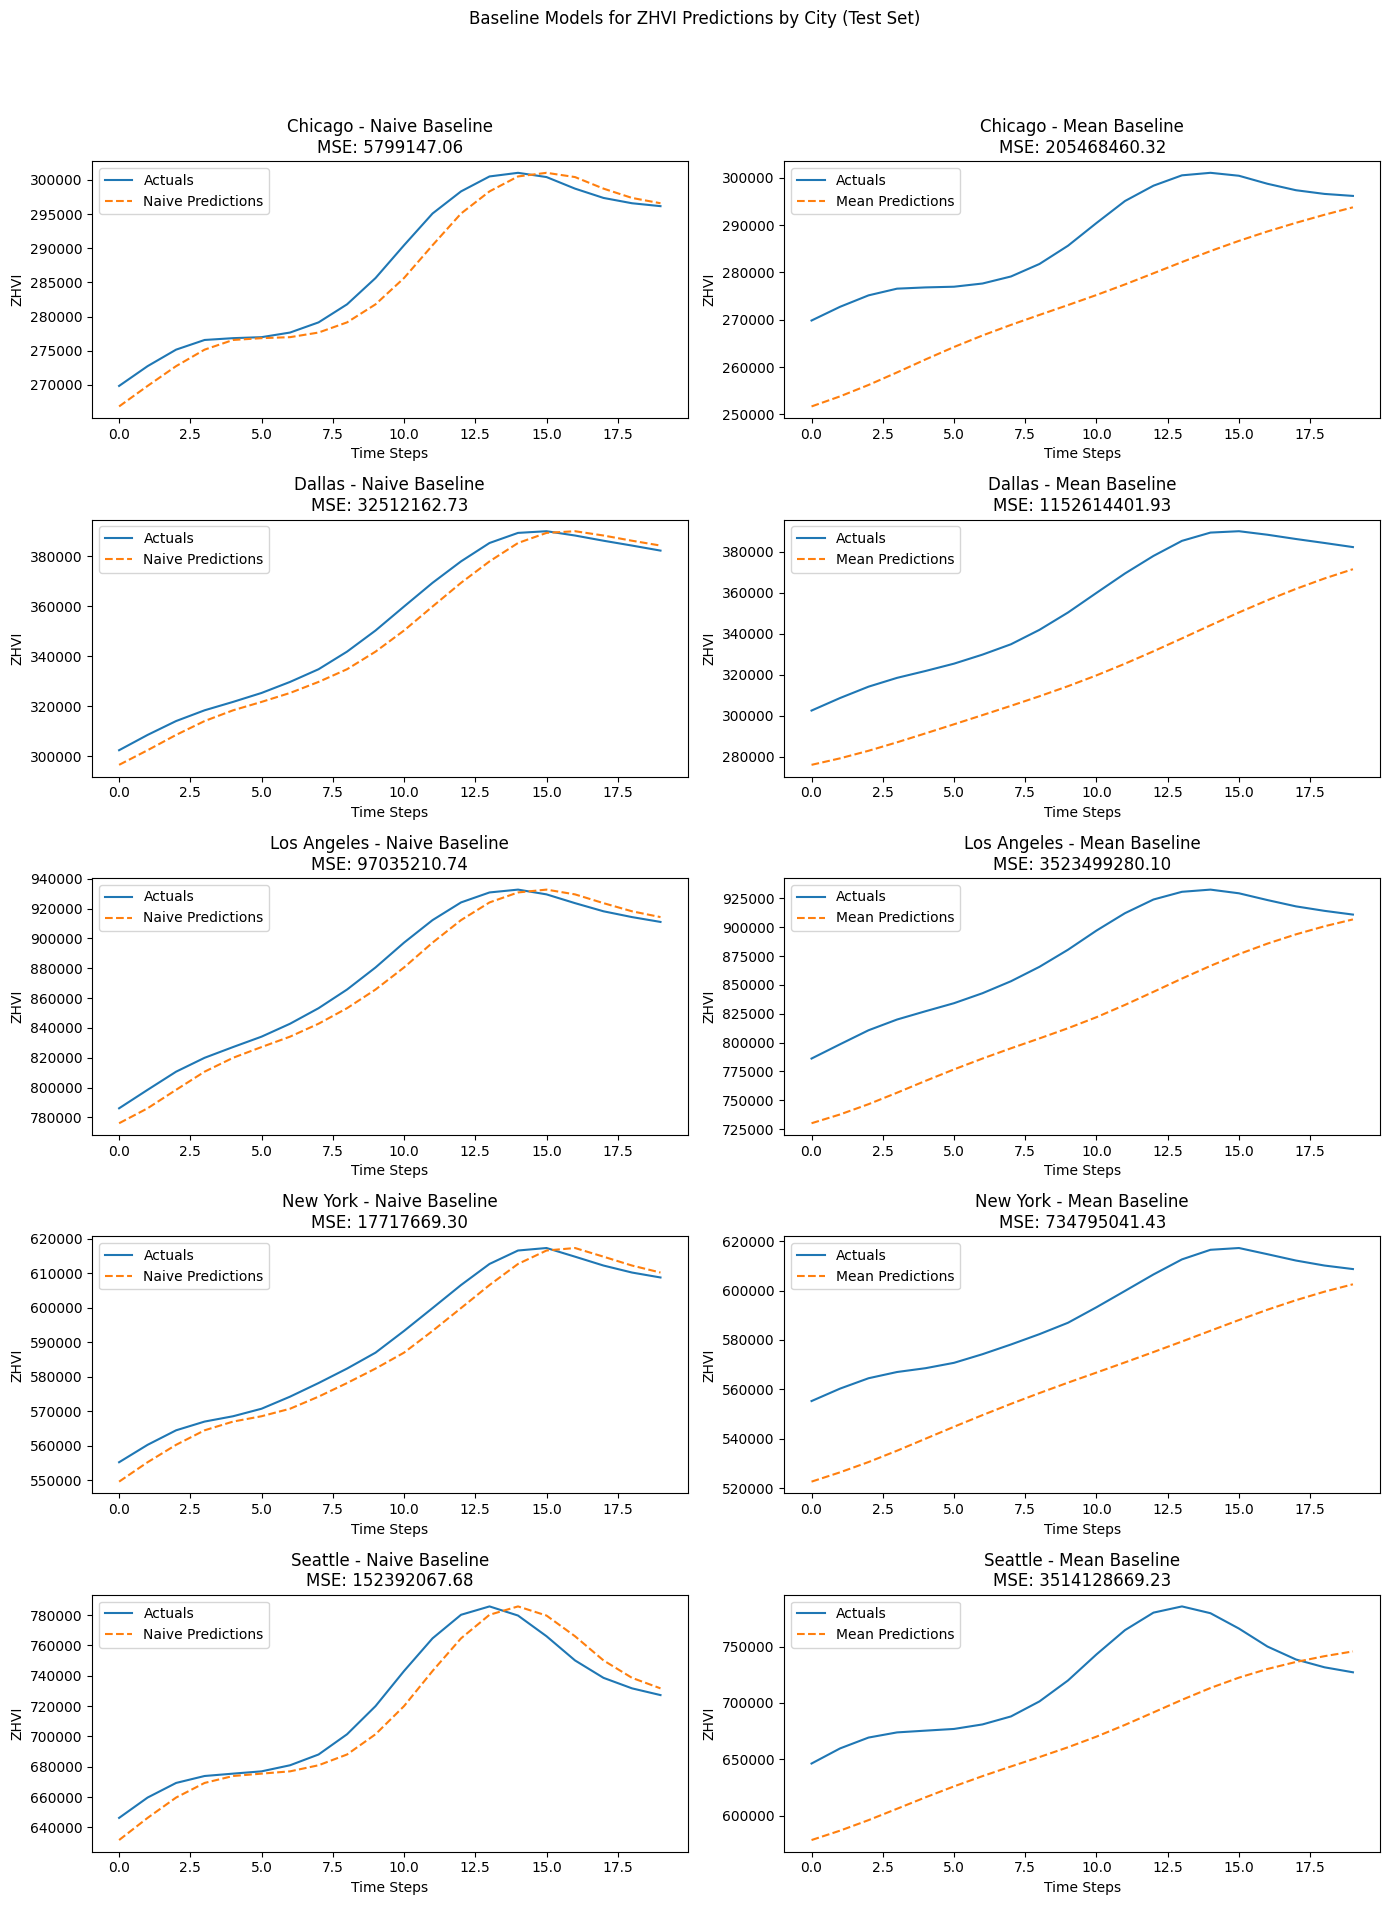

In [27]:
fig, axs = plt.subplots(len(merged_df['City'].unique()), 2, figsize=(14, 20))
fig.suptitle('Baseline Models for ZHVI Predictions by City (Test Set)')

for idx, city in enumerate(merged_df['City'].unique()):
    # Naive Baseline
    axs[idx, 0].plot(actual_vals[city], label='Actuals')
    axs[idx, 0].plot(naive_preds[city], label='Naive Predictions', linestyle='--')
    axs[idx, 0].set_title(f'{city} - Naive Baseline\nMSE: {mse_results[city]["Naive MSE"]:.2f}')
    axs[idx, 0].set_xlabel('Time Steps')
    axs[idx, 0].set_ylabel('ZHVI')
    axs[idx, 0].legend()

    # Mean Baseline
    axs[idx, 1].plot(actual_vals[city], label='Actuals')
    axs[idx, 1].plot(mean_preds[city], label='Mean Predictions', linestyle='--')
    axs[idx, 1].set_title(f'{city} - Mean Baseline\nMSE: {mse_results[city]["Mean MSE"]:.2f}')
    axs[idx, 1].set_xlabel('Time Steps')
    axs[idx, 1].set_ylabel('ZHVI')
    axs[idx, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [28]:
len(actual_vals["Chicago"])

20

# <h1><center>LSTM Model</center></h1>

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Function to preprocess data for LSTM
def preprocess_data(df, window=12):
    # Separate train and test data (80% train, 20% test)
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    # Create sequences of 12 months for training
    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

In [ ]:
# Initialize dictionaries to store processed data
X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}
scalers = {}

# Loop through each city to preprocess the data
for city in merged_df['City'].unique():
    city_data = merged_df[merged_df['City'] == city].reset_index(drop=True)
    X_train_dict[city], y_train_dict[city], X_test_dict[city], y_test_dict[city], scalers[city] = preprocess_data(city_data)

In [ ]:
# Function to create and train LSTM model
def create_and_train_lstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model

# Initialize dictionary to store models
models = {}

for city in merged_df['City'].unique():
    X_train, y_train = X_train_dict[city], y_train_dict[city]
    models[city] = create_and_train_lstm(X_train, y_train)

Epoch 1/100
3/3 [==============================] - 7s 763ms/step - loss: 0.0679 - val_loss: 0.2462
Epoch 2/100
3/3 [==============================] - 0s 57ms/step - loss: 0.0393 - val_loss: 0.1404
Epoch 3/100
3/3 [==============================] - 0s 52ms/step - loss: 0.0114 - val_loss: 0.1481
Epoch 4/100
3/3 [==============================] - 0s 60ms/step - loss: 0.0161 - val_loss: 0.0762
Epoch 5/100
3/3 [==============================] - 0s 29ms/step - loss: 0.0078 - val_loss: 0.0229
Epoch 6/100
3/3 [==============================] - 0s 31ms/step - loss: 0.0065 - val_loss: 0.0193
Epoch 7/100
3/3 [==============================] - 0s 47ms/step - loss: 0.0029 - val_loss: 0.0358
Epoch 8/100
3/3 [==============================] - 0s 45ms/step - loss: 0.0038 - val_loss: 0.0422
Epoch 9/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0043 - val_loss: 0.0228
Epoch 10/100
3/3 [==============================] - 0s 30ms/step - loss: 0.0026 - val_loss: 0.0088
Epoch 11/100
3/3 [

In [ ]:
# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

# Initialize dictionaries to store predictions and actual values
lstm_preds = {}
actual_vals = {}
mse_results = {}

# Loop through each city to make predictions and evaluate the model
for city in merged_df['City'].unique():
    X_test, y_test = X_test_dict[city], y_test_dict[city]
    scaler = scalers[city]

    lstm_preds[city] = make_predictions(models[city], X_test, scaler)
    actual_vals[city] = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
    actual_vals[city] = actual_vals[city][:, 0]  # Only return the ZHVI actuals

    mse = mean_squared_error(actual_vals[city], lstm_preds[city])
    mse_results[city] = mse
    print(f'{city} - LSTM Model MSE: {mse:.2f}')

1/1 [==============================] - 1s 893ms/step
Chicago - LSTM Model MSE: 438524896.00
1/1 [==============================] - 1s 873ms/step
Dallas - LSTM Model MSE: 5695424993.75
1/1 [==============================] - 1s 868ms/step
Los Angeles - LSTM Model MSE: 118862908150.16
1/1 [==============================] - 1s 845ms/step
New York - LSTM Model MSE: 8119322944.72
1/1 [==============================] - 1s 1s/step
Seattle - LSTM Model MSE: 42481872419.60


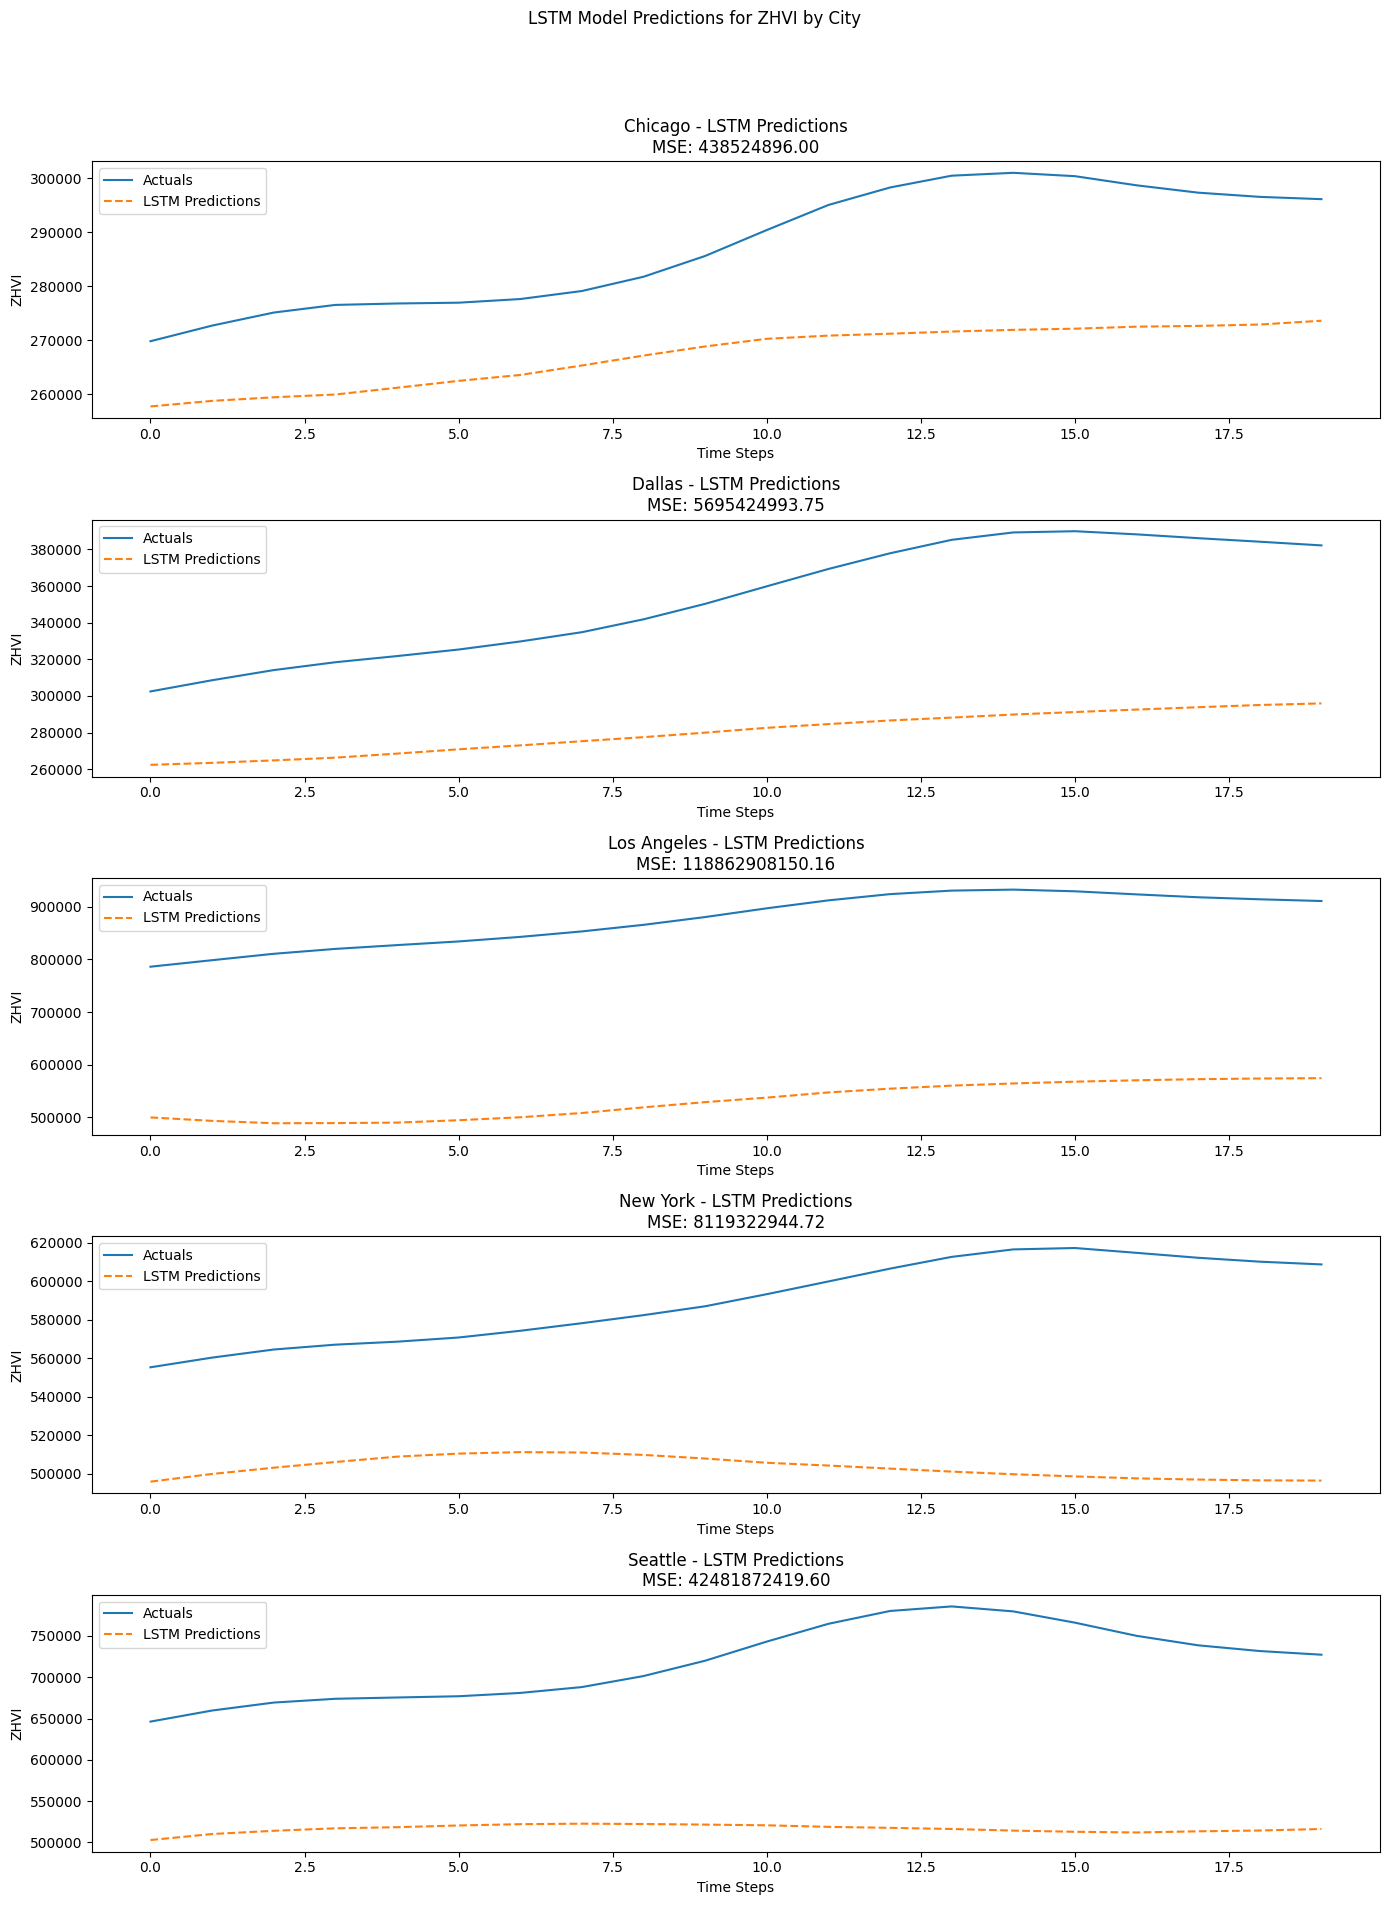

In [ ]:
# Plotting the results for each city
fig, axs = plt.subplots(len(merged_df['City'].unique()), 1, figsize=(14, 20))
fig.suptitle('LSTM Model Predictions for ZHVI by City')

for idx, city in enumerate(merged_df['City'].unique()):
    axs[idx].plot(actual_vals[city], label='Actuals')
    axs[idx].plot(lstm_preds[city], label='LSTM Predictions', linestyle='--')
    axs[idx].set_title(f'{city} - LSTM Predictions\nMSE: {mse_results[city]:.2f}')
    axs[idx].set_xlabel('Time Steps')
    axs[idx].set_ylabel('ZHVI')
    axs[idx].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()